# Training YOLOX on a Custom Drone Dataset
<img src="https://learnopencv.com/wp-content/uploads/2022/10/yolox-object-detector-paper-explnation-and-custom-training.gif" alt="yolox" width="1000">

In this notebook, we will cover the following.

* How to install YOLOX?
* Configuring Training Parameters.
* Train YOLOX on a custom Drone dataset.
* Evaluate
* Inference

Check out accompanying blog post [YOLOX Object Detector Paper Explanation and Custom Training](https://learnopencv.com/yolox-object-detector-paper-explanation-and-custom-training/)
 

## Clone YOLOX Repository

In [1]:
!git clone https://github.com/Megvii-BaseDetection/YOLOX.git

Cloning into 'YOLOX'...
remote: Enumerating objects: 1723, done.
remote: Total 1723 (delta 0), reused 0 (delta 0), pack-reused 1723
Receiving objects: 100% (1723/1723), 6.82 MiB | 23.06 MiB/s, done.
Resolving deltas: 100% (1025/1025), done.


## Install Requirements

In [ ]:
%cd YOLOX
!pip3 install -v -e .

## Define Classes
Since we are using VOC format, by default there will be 20 classes. It is defined in `yolox/data/datasets/voc_classes.py` file. We will modify it to contain only **drone** class. 

In [4]:
from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [5]:
##REPLACE this cell with your classnames stripped of whitespace and lowercase
%%writetemplate yolox/data/datasets/voc_classes.py

VOC_CLASSES = (
  "drone",
)

In [6]:
##REPLACE this cell with your classnames stripped of whitespace and lowercase
%%writetemplate /content/YOLOX/yolox/data/datasets/coco_classes.py

COCO_CLASSES = (
  "drone",
)

## Configuring Training Parameters
In YOLOX, training params are stored in python scripts called experiment files. Example scripts are available in `exps/example/yolox_x_voc/` directory.

These scripts contain definition of the following parameters that we need to modify.

* How to load training data.
* How to load evaluation data.
* Network depth and width.
* Number of Epochs.
* Number of classes.
* How to resize.
* Augmentation info. 
* Loss functions etc.

By default YOLOX has `yolox_voc_s.py` in the `examples` directory. We will utillize the same to create our `yolox_voc_m.py`. 

In [10]:
# Copy experiment config file fpr medium model.
!cp ./exps/example/yolox_voc/yolox_voc_s.py ./exps/example/yolox_voc/yolox_voc_m.py

In [11]:
# Set number of classes.
NUM_CLASSES = 1
!sed -i -e 's/self.num_classes = 20/self.num_classes = {NUM_CLASSES}/g' "exps/example/yolox_voc/yolox_voc_m.py"

In [ ]:
# Set maximum number of epochs.
# Warning! Running this cell multiple times will create two lines.
MAX_EPOCH = 25
!sed -i '/self.warmup_epochs = 1/a \ \ \ \ \ \ \ \ self.max_epoch={MAX_EPOCH}' "exps/example/yolox_voc/yolox_voc_m.py"

In [13]:
# Set network depth for medium model.
DEPTH = 0.67
!sed -i -e 's/self.depth = 0.33/self.depth = {DEPTH}/g' "exps/example/yolox_voc/yolox_voc_m.py"

# Set network width for medium model.
WIDTH = 0.75
!sed -i -e 's/self.width = 0.50/self.width = {WIDTH}/g' "exps/example/yolox_voc/yolox_voc_m.py"

In [3]:
%cd datasets
!wget https://www.dropbox.com/s/rdry0luc5rnoec2/Drone-Dataset.zip?dl=1 -O VOCdevkit.zip -q --show-progress
!unzip -qq VOCdevkit.zip
!rm VOCdevkit.zip
%cd ..

/content/YOLOX/datasets
VOCdevkit.zip       100%[===================>]  50.28M  21.9MB/s    in 2.3s    
/content/YOLOX


## Download Pre-trained YOLOX medium weights

Available in [YOLOX GitHub releases](https://github.com/Megvii-BaseDetection/YOLOX/releases).

In [ ]:
!wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_m.pth

## Download Dataset
The dataset is in following order.
```
VOCdevkit
  |___VOC2012
     |___Annotations
     |___ImageSets
            |___Main
                   |___train.txt
                   |___valid.txt
     |___JPEGImages
```

In [ ]:
%cd datasets
!wget https://www.dropbox.com/s/rdry0luc5rnoec2/Drone-Dataset.zip?dl=1 -O VOCdevkit.zip -q --show-progress
!unzip -qq VOCdevkit.zip
!rm VOCdevkit.zip
%cd ..

## TensorBoard

## Set Train and Validation Data Path [**Important**] 

Go to `exps/example/yolox_voc/`. You will see two experiment files, `yolox_voc_s.py` and `yolox_voc_m.py`. Since we are training the `medium` model, we are concerned about `yolox_voc_m.py`. We are simply changing the Training and Validation data path according to our dataset. Look for `data_loader` and `eval_loader` functions in `yolox_voc_m.py` and modify the following as shown.

**data_loader** function
* ` image_sets=[('2007', 'trainval'), ('2012', 'trainval')],` ---------> `image_sets=[('2012', 'train')],`.

**eval_loader** function
* ` image_sets=[('2007', 'test')],` ---------> ` image_sets=[('2012', 'valid')],

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/YOLOX/YOLOX_outputs/yolox_voc_m/tensorboard/

## Train

In [26]:
!python tools/train.py -f exps/example/yolox_voc/yolox_voc_m.py -d 1 -b 16 --fp16 -o -c yolox_m.pth

2022-10-05 09:14:49 | INFO     | yolox.core.trainer:130 - args: Namespace(batch_size=16, cache=False, ckpt='yolox_m.pth', devices=1, dist_backend='nccl', dist_url=None, exp_file='exps/example/yolox_voc/yolox_voc_m_25.py', experiment_name='yolox_voc_m_25', fp16=True, logger='tensorboard', machine_rank=0, name=None, num_machines=1, occupy=True, opts=[], resume=False, start_epoch=None)
2022-10-05 09:14:49 | INFO     | yolox.core.trainer:131 - exp value:
╒═══════════════════╤════════════════════════════╕
│ keys              │ values                     │
╞═══════════════════╪════════════════════════════╡
│ seed              │ None                       │
├───────────────────┼────────────────────────────┤
│ output_dir        │ './YOLOX_outputs'          │
├───────────────────┼────────────────────────────┤
│ print_interval    │ 10                         │
├───────────────────┼────────────────────────────┤
│ eval_interval     │ 10                         │
├───────────────────┼──────────────

## Evaluate

In [29]:
MODEL_PATH = "YOLOX_outputs/yolox_voc_m/best_ckpt.pth"
!python3 tools/eval.py -c {MODEL_PATH} -b 16 -d 1 --conf 0.001 -f exps/example/yolox_voc/yolox_voc_m.py

2022-10-05 09:36:16 | INFO     | __main__:139 - Args: Namespace(batch_size=16, ckpt='YOLOX_outputs/yolox_voc_m_25/best_ckpt.pth', conf=0.001, devices=1, dist_backend='nccl', dist_url=None, exp_file='exps/example/yolox_voc/yolox_voc_m_25.py', experiment_name='yolox_voc_m_25', fp16=False, fuse=False, legacy=False, machine_rank=0, name=None, nms=None, num_machines=1, opts=[], seed=None, speed=False, test=False, trt=False, tsize=None)
2022-10-05 09:36:17 | INFO     | __main__:149 - Model Summary: Params: 25.28M, Gflops: 73.73
2022-10-05 09:36:17 | INFO     | __main__:150 - Model Structure:
YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
   

## Inference


In [32]:
# Download Images
%mkdir inference_media
%cd inference_media
!wget https://www.dropbox.com/s/1dy29ys1fkce8k3/bird-and-drone.png?dl=1 -O bird-and-drone.jpg -qq --show-progress
!wget https://www.dropbox.com/s/i0afm1nqm6iiuji/eagle-capturing-drone.png?dl=1 -O eagle-capturing-drone.jpg -qq --show-progress
!wget https://www.dropbox.com/s/kje4h0avj2scgjj/eagle-vs-drone.png?dl=1 -O eagle-vs-drone.jpg -qq --show-progress
!wget https://www.dropbox.com/s/jhjy3lfl5908vta/drone-vs-birds.jpg?dl=1 -O drone-vs-birds.jpg -qq --show-progress
%cd ..

/content/YOLOX/inference_media
bird-and-drone.jpg  100%[===================>]   1.56M  2.15MB/s    in 0.7s    
eagle-capturing-dro 100%[===================>] 676.16K  1.08MB/s    in 0.6s    
eagle-vs-drone.jpg  100%[===================>] 333.88K   867KB/s    in 0.4s    
drone-vs-birds.jpg  100%[===================>] 100.34K  --.-KB/s    in 0.009s  
/content/YOLOX


In [34]:
!python tools/demo.py image -f exps/example/yolox_voc/yolox_voc_m_25.py -c {MODEL_PATH} --path ./inference_media/ --conf 0.25 --nms 0.45 --tsize 640 --save_result --device gpu

2022-10-05 10:33:52.984 | INFO     | __main__:main:259 - Args: Namespace(camid=0, ckpt='YOLOX_outputs/yolox_voc_m_25/best_ckpt.pth', conf=0.25, demo='image', device='gpu', exp_file='exps/example/yolox_voc/yolox_voc_m_25.py', experiment_name='yolox_voc_m_25', fp16=False, fuse=False, legacy=False, name=None, nms=0.45, path='./inference_media/', save_result=True, trt=False, tsize=640)
2022-10-05 10:33:53.462 | INFO     | __main__:main:269 - Model Summary: Params: 25.28M, Gflops: 73.73
2022-10-05 10:33:55.353 | INFO     | __main__:main:282 - loading checkpoint
2022-10-05 10:33:56.377 | INFO     | __main__:main:286 - loaded checkpoint done.
2022-10-05 10:33:58.102 | INFO     | __main__:inference:165 - Infer time: 1.6743s
2022-10-05 10:33:58.108 | INFO     | __main__:image_demo:202 - Saving detection result in ./YOLOX_outputs/yolox_voc_m_25/vis_res/2022_10_05_10_33_56/bird-and-drone.jpg
2022-10-05 10:33:58.192 | INFO     | __main__:inference:165 - Infer time: 0.0391s
2022-10-05 10:33:58.193 

In [35]:
import matplotlib.pyplot as plt
import cv2
import glob

In [38]:
images = []
for file in glob.glob("YOLOX_outputs/yolox_voc_m/vis_res/**/*.jpg"):
  img = cv2.imread(file)
  images.append(img)

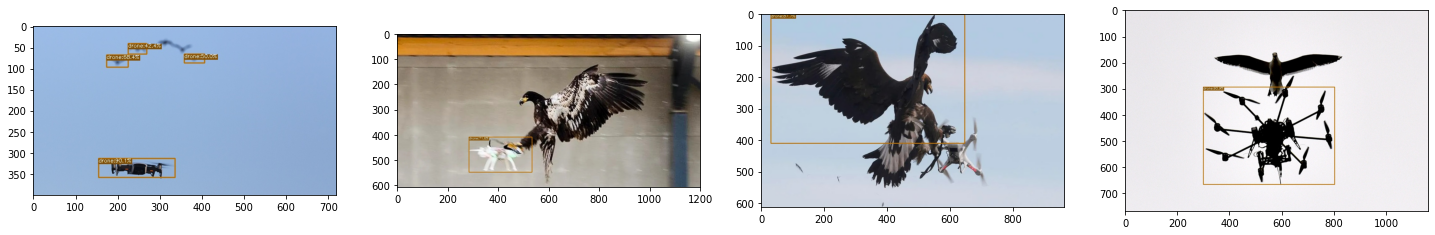

In [39]:
plt.figure(figsize=(25,15))
for i in range(len(images)):
  plt.subplot(1, len(images), i+1); 
  plt.imshow(images[i][...,::-1]);

## Video Inference

In [ ]:
!wget https://www.dropbox.com/s/u1kqu0yxj07e35e/Drones-1-original.mp4?dl=1 -O Drones-1-original.mp4 -qq --show-progress

In [ ]:
!python tools/demo.py video -f exps/example/yolox_voc/yolox_voc_m.py -c {MODEL_PATH} --path Drones-1-original.mp4 --conf 0.25 --nms 0.45 --tsize 640 --save_result --device gpu